In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import graphviz
from graphviz import Graph

from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

## Using the titanic data, in your classification-exercises repository, create a notebook, model.ipynb where you will do the following:

- What is your baseline prediction? <b> predicting survivability </b>

- What is your baseline accuracy? <b> 61.6%</b> remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

- Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample) <b> complete</b>

- Evaluate your in-sample results using the model score, confusion matrix, and classification report. <b> complete</b>

- Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support. <b>complete, see classification report</b>

- Run through steps 2-4 using a different max_depth value. <b> complete, depth value of 3 works best</b> 

- Which model performs better on your in-sample data? <b> model with depth of 3</b>

- Which model performs best on your out-of-sample data, the validate set? <b> The model with a depth of 3</b>

In [ ]:
df = pd.read_csv('/Users/davidberchelmann/codeup-data-science/classification-exercises/titanic_df.csv')

def handle_missing_values(df):
    return df.assign(
        embark_town=df.embark_town.fillna('Other'),
        embarked=df.embarked.fillna('O'),
    )

def remove_columns(df):
    return df.drop(columns=['deck'])

def encode_embarked(df):
    encoder = LabelEncoder()
    encoder.fit(df.embarked)
    return df.assign(embarked_encode = encoder.transform(df.embarked))

def prep_titanic_data(df):
    df = df\
        .pipe(handle_missing_values)\
        .pipe(remove_columns)\
        .pipe(encode_embarked)
    return df

def train_validate_test_split(df, seed=123):
    train_and_validate, test = train_test_split(
        df, test_size=0.2, random_state=seed, stratify=df.survived
    )
    train, validate = train_test_split(
        train_and_validate,
        test_size=0.3,
        random_state=seed,
        stratify=train_and_validate.survived,
    )
    return train, validate, test





In [ ]:
# check out data columns first before cleaning. Get rid of 'Unnamed', 'passenger_id', 'pclass', 'age', 'sibsp', 'parch'
# rename survived column to 'yes' 'no' and use as target variable

df.head()


In [ ]:
# clean data followed by creating train/validate/test function

def clean_titanic():
    '''
    clean_titanic will take a dataframe acquired as df and remove columns that are:
    duplicates,
    have too many nulls,
    and will fill in smaller amounts of nulls in embark_town
    encode sex and embark_town columns
    
    return: single cleaned dataframe
    '''
    df.drop_duplicates(inplace=True)
    dropcols = ['age', 'deck', 'embarked', 'Unnamed: 0', 'passenger_id', 'pclass', 'sibsp', 'parch']
    df.drop(columns=dropcols, inplace=True)
    df['embark_town'] = df['embark_town'].fillna('Southampton')
    dummies = pd.get_dummies(df[['embark_town', 'sex', 'class']], drop_first=True)
    return pd.concat([df, dummies], axis=1)


def train_validate_test_split(df, seed=123):
    train_and_validate, test = train_test_split(
        df, test_size=0.2, random_state=seed, stratify=df.survived
    )
    train, validate = train_test_split(
        train_and_validate,
        test_size=0.3,
        random_state=seed,
        stratify=train_and_validate.survived,
    )
    return train, validate, test



In [ ]:
# clean data using function from above

df = clean_titanic()

In [ ]:
# rename survied column to using a no/yes in place of 0/1

#df['survived'] = df['survived'].replace([0,1],['no', 'yes'])

In [ ]:
# check columns to make sure changes have been made

df.head()

In [ ]:
# Split the data
# stratifying means we're making representative datasets between train, validate, test
train, validate, test = train_validate_test_split(df, seed=123)
train.head()

In [ ]:
# Setup our X inputs and y target variable for each split
X_train = train.drop(columns=['survived', 'sex', 'embark_town', 'class'])
y_train = train.survived # labeled data == supervise algorithm

X_validate = validate.drop(columns=['survived', 'sex', 'embark_town', 'class'])
y_validate = validate.survived

X_test = test.drop(columns=['survived', 'sex', 'embark_town', 'class'])
y_test = test.survived

In [ ]:
# check training data

train.head()

In [ ]:
df.groupby('survived').sex.value_counts()

In [ ]:
train.groupby('survived').sex.value_counts()

In [ ]:
# Let's generate a blank, new Decision Tree model
# Be sure to set the max_depth argument
# clf = DecisionTreeClassifier(max_depth=3, random_state=123)

clf = DecisionTreeClassifier(max_depth=3, random_state=123)


In [ ]:
# Now let's train our model on the training data
# fitting == training the model
clf = clf.fit(X_train, y_train)
clf

In [ ]:
train.survived.unique()

In [ ]:
clf.classes_

In [ ]:
train["most_frequent"] = 0

In [ ]:
train['most_frequent'].value_counts()

In [ ]:
# Visualize the model so it can explain itself!

dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True, format="pdf")

In [ ]:
# Now we'll make a set of predictions using this trained model
y_pred = clf.predict(X_train)
y_pred[0:3]

In [ ]:
# Estimate the probabilities for each class
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:3]

In [ ]:
y_train.head(3)

In [ ]:

baseline_accuracy = (train.survived == train.most_frequent).mean()
baseline_accuracy 

In [ ]:
# Let's evaluate the model
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

In [ ]:
accuracy = clf.score(X_train, y_train)
accuracy

In [ ]:
conf = confusion_matrix(y_train, y_pred)
conf

In [ ]:
class_report = classification_report(y_train, y_pred, output_dict=True)

In [ ]:
pd.DataFrame(class_report).T

In [ ]:
conf_df = pd.DataFrame(conf, columns=['predict_death', 'predict_survive'], index=['actual_death', 'actual_survive'])

conf_df

In [ ]:
# clf was trained on X_train, y_train
# To evaluate the model trained on new data, the arguments coming into .score()
clf.score(X_validate, y_validate)

In [ ]:
# Let's evaluate this model on out-of-sample data
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

In [ ]:
# Use the classification model trained on train data to make predictions on validate data
y_pred = clf.predict(X_validate)
y_pred[0:3]

In [ ]:
y_validate.head(3)

In [ ]:
# Compare actual y values from validate to predictions based on X_validate
print(classification_report(y_validate, y_pred))

In [ ]:
not_male = train[train.sex_male > 0.5]

In [ ]:
fare = not_male[not_male.fare <= 18.275]

In [ ]:
fare.head()

In [ ]:
alone = fare[fare.alone <=.5]

In [ ]:
alone.survived.value_counts()

In [ ]:
# Visualize the model so it can explain itself!

dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True, format="pdf")

In [ ]:
# run new model with depth of 2
clf1 = DecisionTreeClassifier(max_depth=2, random_state=123)


In [ ]:
# Now let's train our model on the training data
# fitting == training the model
clf1 = clf1.fit(X_train, y_train)
clf1

In [ ]:
y_pred = clf1.predict(X_train)
y_pred[0:3]

In [ ]:
# Estimate the probabilities for each class
y_pred_proba = clf1.predict_proba(X_train)
y_pred_proba[0:3]

In [ ]:
# clf was trained on X_train, y_train
# To evaluate the model trained on new data, the arguments coming into .score()
clf1.score(X_validate, y_validate)

In [ ]:
# Let's evaluate this model on out-of-sample data
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf1.score(X_validate, y_validate)))

In [ ]:
#----------------------------------------------------------------------

from sklearn.ensemble import RandomForestClassifier

### Random Forest Exercises

- Continue working in your model file with titanic data to do the following:

- Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

- Evaluate your results using the model score, confusion matrix, and classification report.

- Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

- Run through steps increasing your min_samples_leaf and decreasing your max_depth.

- What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

- After making a few models, which one has the best performance (or closest metrics) on both train and validate?

In [ ]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
print(rf.feature_importances_)

In [ ]:
y_pred = rf.predict(X_train)

In [ ]:
y_pred_proba = rf.predict_proba(X_train)

In [ ]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

In [ ]:
print(confusion_matrix(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

In [ ]:
# create a function to calculate these metrics
def get_metrics_binary(rf):
    '''
    get_metrics_binary takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    accuracy = rf.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report
    

In [ ]:
class_report1 = get_metrics_binary(rf)
class_report1

In [ ]:
#-------------------------------------

In [ ]:
rf2 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)

In [ ]:
rf2.fit(X_train, y_train)

In [ ]:
print(rf2.feature_importances_)

In [ ]:
y_pred = rf2.predict(X_train)

In [ ]:
y_pred_proba = rf2.predict_proba(X_train)

In [ ]:
print(confusion_matrix(y_train, y_pred))

In [ ]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf2.score(X_train, y_train)))

In [ ]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf2.score(X_validate, y_validate)))

In [ ]:
class_report2 = get_metrics_binary(rf2)

class_report2

In [ ]:
# get predictions for our validation sets
y_val_pred_1 = rf.predict(validate.drop(columns=['survived', 'sex', 'embark_town', 'class']))
y_val_pred_2 = rf2.predict(validate.drop(columns=['survived', 'sex', 'embark_town', 'class']))

In [ ]:
# get validation accuracy
accuracy_v_1 = rf.score(validate.drop(columns=['survived', 'sex', 'embark_town', 'class']), validate.survived)
accuracy_v_2 = rf2.score(validate.drop(columns=['survived', 'sex', 'embark_town', 'class']), validate.survived)
accuracy_v_3 = rf3.score(validate.drop(columns=['survived', 'sex', 'embark_town', 'class']), validate.survived)

In [ ]:
accuracy_v_1

In [ ]:
accuracy_v_2

In [ ]:
accuracy_v_3

- What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

    <b>The first model performed best on the in sample data which had a depth of 10 and min samples of 1.</b>
    
- After making a few models, which one has the best performance (or closest metrics) on both train and validate?

    <b>The second model performed slightly better on validate (1 percentage point) while the first model had a higher performance on train data.</b>

In [ ]:
rf3 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [ ]:
rf3.fit(X_train, y_train)

In [ ]:
print(rf3.feature_importances_)

In [ ]:
y_pred = rf3.predict(X_train)

In [ ]:
y_pred_proba = rf3.predict_proba(X_train)

In [ ]:
print(confusion_matrix(y_train, y_pred))

In [ ]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf3.score(X_train, y_train)))

In [ ]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf3.score(X_validate, y_validate)))

In [ ]:
class_report3 = get_metrics_binary(rf3)

class_report3

In [ ]:
print('------------------------\n Model #1')

print(class_report1) 

print('------------------------\n Model #2')

print(class_report2)

print('------------------------\n Model #3')

print(class_report3)

# KNN Exercises

- Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

- Evaluate your results using the model score, confusion matrix, and classification report.

- Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

- Run through steps 2-4 setting k to 10

- Run through setps 2-4 setting k to 20

- What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

- Which model performs best on our out-of-sample data from validate?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

##### Note to self: when running your inputs and target variables, you can't have 'most_frequent' as a column in X_train or else you validate and test won't work properly.

In [ ]:
# Setup our X inputs and y target variable for each split
X_train = train.drop(columns=['survived', 'sex', 'embark_town', 'class', 'most_frequent'])
y_train = train.survived # labeled data == supervise algorithm

X_validate = validate.drop(columns=['survived', 'sex', 'embark_town', 'class'])
y_validate = validate.survived

X_test = test.drop(columns=['survived', 'sex', 'embark_town', 'class'])
y_test = test.survived

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
# Now let's train the model

knn.fit(X_train, y_train)

In [ ]:
# Let's check the accuracy
accuracy = knn.score(X_train, y_train)
print(f"accuracy is {accuracy:.3}")

In [ ]:
# Evaluate the model
y_pred = knn.predict(X_train)

In [ ]:
# Let's see how well this model performs on out of sample data!
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

In [ ]:
# Obtain the predictions from the model
y_pred1 = knn.predict(X_validate)

In [ ]:
def get_metrics_binary(knn):
    '''
    get_metrics_binary takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    accuracy = knn.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report

In [ ]:
class_report_knn = get_metrics_binary(knn)

class_report_knn

In [ ]:
# Let's check our other classification metrics
print(classification_report(y_validate, y_pred1))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
# Let's check the accuracy
accuracy = knn.score(X_train, y_train)
print(f"accuracy is {accuracy:.3}")

In [ ]:
# Evaluate the model
y_pred = knn.predict(X_train)

In [ ]:
# Let's see how well this model performs on out of sample data!
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

In [ ]:
# Obtain the predictions from the model
y_pred1 = knn.predict(X_validate)

In [ ]:
def get_metrics_binary(knn):
    '''
    get_metrics_binary takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    accuracy = knn.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report

In [ ]:
class_report_knn_10 = get_metrics_binary(knn)

class_report_knn_10

In [ ]:
# Let's check our other classification metrics
print(classification_report(y_validate, y_pred1))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=20)

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
# Let's check the accuracy
accuracy = knn.score(X_train, y_train)
print(f"accuracy is {accuracy:.3}")

In [ ]:
# Evaluate the model
y_pred = knn.predict(X_train)

In [ ]:
# Let's see how well this model performs on out of sample data!
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

In [ ]:
# Obtain the predictions from the model
y_pred1 = knn.predict(X_validate)

In [ ]:
def get_metrics_binary(knn):
    '''
    get_metrics_binary takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    accuracy = knn.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report

In [ ]:
class_report_knn_20 = get_metrics_binary(knn)

class_report_knn_20

In [ ]:
# Let's check our other classification metrics
print(classification_report(y_validate, y_pred1))

In [ ]:
outcomes = []
for k in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=k)    
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_validate, y_validate)
    test_accuracy = knn.score(X_test, y_test)
    output = {}
    output["k"] = k
    output["accuracy"] = accuracy
    output["validate_accuracy"] = validate_accuracy
    output["test_accuracy"] = test_accuracy
    outcomes.append(output)

In [ ]:
pd.DataFrame(outcomes)

In [ ]:
outcomes = []
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)    
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_validate, y_validate)
    test_accuracy = knn.score(X_test, y_test)
    output = {}
    output["k"] = k
    output["accuracy"] = accuracy
    output["validate_accuracy"] = validate_accuracy
    output["test_accuracy"] = test_accuracy
    outcomes.append(output)

In [ ]:
pd.DataFrame(outcomes)

### Logistic Regression Exercises

In these exercises, we'll continue working with the titanic dataset and building logistic regression models. Throughout this exercise, be sure you are training, evaluation, and comparing models on the train and validate datasets. The test dataset should only be used for your final model.

For all of the models you create, choose a threshold that optimizes for accuracy.

Do your work for these exercises in either a notebook or a python script named model within your classification-exercises repository. Add, commit, and push your work.

- Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?

- Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.

- Try out other combinations of features and models.

- Use you best 3 models to predict and evaluate on your validate sample.

- Choose you best model from the validation performation, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?

In [2]:
from sklearn.linear_model import LogisticRegression
import logistic_regression_util


In [3]:
df = pd.read_csv('/Users/davidberchelmann/codeup-data-science/classification-exercises/titanic_df.csv')

In [4]:
# clean data followed by creating train/validate/test function

def clean_titanic(df):
    '''
    clean_titanic will take a dataframe acquired as df and remove columns that are:
    duplicates,
    have too many nulls,
    and will fill in smaller amounts of nulls in embark_town
    encode sex and embark_town columns
    
    return: single cleaned dataframe
    '''
    df.drop_duplicates(inplace=True)
    dropcols = ['deck', 'embarked', 'Unnamed: 0', 'passenger_id', 'sibsp', 'parch', 'embark_town', 'alone', 'class']
    df.drop(columns=dropcols, inplace=True)
    df.dropna(how = 'any', inplace = True)
    dummies = pd.get_dummies(df[['sex']], drop_first=True)
    return pd.concat([df, dummies], axis=1)


def train_validate_test_split(df, seed=123):
    train_and_validate, test = train_test_split(
        df, test_size=0.2, random_state=seed, stratify=df.survived
    )
    train, validate = train_test_split(
        train_and_validate,
        test_size=0.3,
        random_state=seed,
        stratify=train_and_validate.survived,
    )
    return train, validate, test



In [5]:
df2 = clean_titanic(df)

### Model 1

- Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline? <b> Yes, it beats the baseline by 11 percentage points</b>

In [6]:
dropcols = ['sex_male', 'sex']
df2.drop(columns=dropcols, inplace=True)

In [7]:
#train_test_validate

train, validate, test = train_validate_test_split(df2)

In [8]:
print(train.shape)
print(validate.shape)
print(test.shape)

(399, 4)
(172, 4)
(143, 4)


In [9]:
train.survived.value_counts()

0    237
1    162
Name: survived, dtype: int64

In [10]:
df2.head()

,survived,pclass,age,fare
0,0,3,22.0,7.2500
1,1,1,38.0,71.2833
2,1,3,26.0,7.9250
3,1,1,35.0,53.1000
4,0,3,35.0,8.0500


In [11]:
# Make new dataframes
X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [12]:
X_train.head()

,pclass,age,fare
652,3,21.0,8.4333
813,3,6.0,31.2750
194,1,44.0,27.7208
417,2,18.0,13.0000
460,1,48.0,26.5500


In [13]:
X_train.shape, y_train.shape

((399, 3), (399,))

In [14]:
train["most_frequent"] = 0

In [15]:

baseline_accuracy = (train.survived == train.most_frequent).mean()
baseline_accuracy 

0.5939849624060151

In [16]:
logit = LogisticRegression(C=1,
                           random_state=123)

In [17]:
#  fit the model on train data
logit.fit(X_train, y_train)

LogisticRegression(C=1, random_state=123)

In [18]:
# now use the model to make predictions
y_pred = logit.predict(X_train)

In [19]:
#take a look at predictions
y_pred

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,

In [20]:
# View raw probabilities (output from the model)


y_pred_proba = logit.predict_proba(X_train)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['passed away', 'survived'])
y_pred_proba.head()

,passed away,survived
0,0.732344,0.267656
1,0.587198,0.412802
2,0.388311,0.611689
3,0.421519,0.578481
4,0.428695,0.571305


In [21]:
# classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.82      0.76       237
           1       0.66      0.52      0.59       162

    accuracy                           0.70       399
   macro avg       0.69      0.67      0.67       399
weighted avg       0.69      0.70      0.69       399



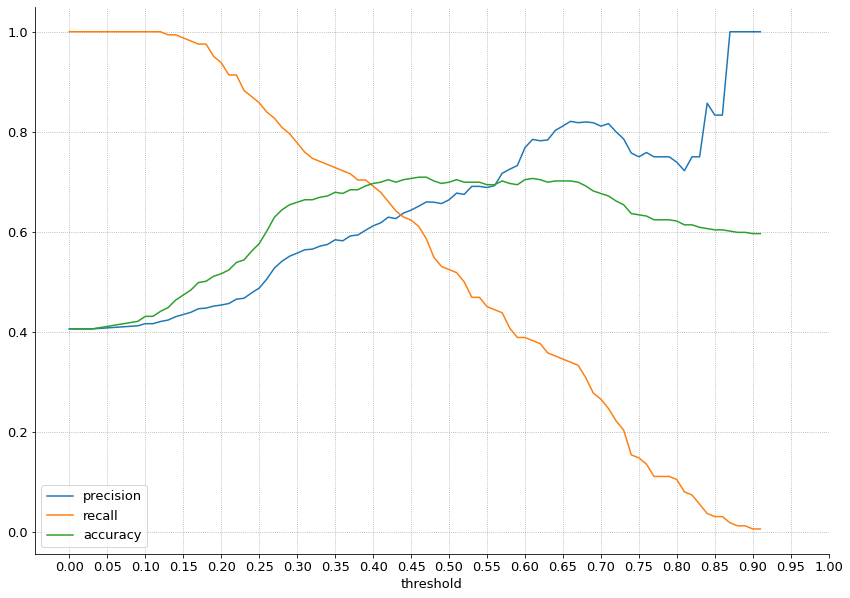

In [22]:
# plot metrics vs thresholds
logistic_regression_util.plot_metrics_by_thresholds(y_train, y_pred_proba.survived)

### Model 2

- Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model. 
    - <b>Doing this increased the accuracy by 20 percentage points</b>

In [23]:
df3 = pd.read_csv('/Users/davidberchelmann/codeup-data-science/classification-exercises/titanic_df.csv')

In [24]:
df3 = clean_titanic(df3)

In [25]:
dropcols1 = ['sex']
df3.drop(columns=dropcols1, inplace=True)

In [26]:
df3.head()

,survived,pclass,age,fare,sex_male
0,0,3,22.0,7.2500,1
1,1,1,38.0,71.2833,0
2,1,3,26.0,7.9250,0
3,1,1,35.0,53.1000,0
4,0,3,35.0,8.0500,1


In [27]:
train, validate, test = train_validate_test_split(df3)


In [28]:
print(train.shape)
print(validate.shape)
print(test.shape)

(399, 5)
(172, 5)
(143, 5)


In [29]:
# Make new dataframes
X_train1 = train.drop(columns=['survived'])
y_train = train.survived

X_validate1 = validate.drop(columns=['survived'])
y_validate1 = validate.survived

X_test1 = test.drop(columns=['survived'])
y_test = test.survived

In [30]:
logit2 = LogisticRegression(C=1,
                           random_state=123)

In [31]:
#  fit the model on train data
logit2.fit(X_train1, y_train)

LogisticRegression(C=1, random_state=123)

In [32]:
# now use the model to make predictions
y_pred = logit2.predict(X_train1)

In [33]:
# View raw probabilities (output from the model)


y_pred_proba = logit2.predict_proba(X_train1)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['passed away', 'survived'])
y_pred_proba.head()

,passed away,survived
0,0.872486,0.127514
1,0.323882,0.676118
2,0.128001,0.871999
3,0.177899,0.822101
4,0.604015,0.395985


In [34]:
# classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       237
           1       0.75      0.70      0.73       162

    accuracy                           0.79       399
   macro avg       0.78      0.77      0.78       399
weighted avg       0.79      0.79      0.79       399



### Try out other combinations of features and models.

In [35]:
df4 = pd.read_csv('/Users/davidberchelmann/codeup-data-science/classification-exercises/titanic_df.csv')

In [36]:
# clean data followed by creating train/validate/test function

def clean_titanic(df):
    '''
    clean_titanic will take a dataframe acquired as df and remove columns that are:
    duplicates,
    have too many nulls,
    and will fill in smaller amounts of nulls in embark_town
    encode sex and embark_town columns
    
    return: single cleaned dataframe
    '''
    df.drop_duplicates(inplace=True)
    dropcols = ['deck', 'embarked', 'Unnamed: 0', 'passenger_id', 'sibsp', 'parch', 'class']
    df.drop(columns=dropcols, inplace=True)
    df.dropna(how = 'any', inplace = True)
    df['embark_town'] = df['embark_town'].fillna('Southampton')
    dummies = pd.get_dummies(df[['embark_town', 'sex']], drop_first=True)
    return pd.concat([df, dummies], axis=1)


def train_validate_test_split(df, seed=123):
    train_and_validate, test = train_test_split(
        df, test_size=0.2, random_state=seed, stratify=df.survived
    )
    train, validate = train_test_split(
        train_and_validate,
        test_size=0.3,
        random_state=seed,
        stratify=train_and_validate.survived,
    )
    return train, validate, test



In [37]:
df4 = clean_titanic(df4)

In [38]:
dropcols2 = ['sex', 'embark_town']
df4.drop(columns=dropcols2, inplace=True)

In [39]:
df4.head()

,survived,pclass,age,fare,alone,embark_town_Queenstown,embark_town_Southampton,sex_male
0,0,3,22.0,7.2500,0,0,1,1
1,1,1,38.0,71.2833,0,0,0,0
2,1,3,26.0,7.9250,1,0,1,0
3,1,1,35.0,53.1000,0,0,1,0
4,0,3,35.0,8.0500,1,0,1,1


In [40]:
train, validate, test = train_validate_test_split(df4)


In [41]:
print(train.shape)
print(validate.shape)
print(test.shape)

(398, 8)
(171, 8)
(143, 8)


In [42]:
# Make new dataframes
X_train2 = train.drop(columns=['survived'])
y_train = train.survived

X_validate2 = validate.drop(columns=['survived'])
y_validate2 = validate.survived

X_test2 = test.drop(columns=['survived'])
y_test = test.survived

In [43]:
logit3 = LogisticRegression(C=1,
                           random_state=123)

In [44]:
#  fit the model on train data
logit3.fit(X_train2, y_train)

LogisticRegression(C=1, random_state=123)

In [45]:
# now use the model to make predictions
y_pred = logit3.predict(X_train2)

In [46]:
# View raw probabilities (output from the model)


y_pred_proba = logit3.predict_proba(X_train2)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['passed away', 'survived'])
y_pred_proba.head()

,passed away,survived
0,0.803788,0.196212
1,0.784111,0.215889
2,0.925032,0.074968
3,0.609754,0.390246
4,0.846272,0.153728


In [47]:
# classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       237
           1       0.78      0.72      0.75       161

    accuracy                           0.81       398
   macro avg       0.80      0.79      0.80       398
weighted avg       0.81      0.81      0.81       398



In [48]:
df5 = pd.read_csv('/Users/davidberchelmann/codeup-data-science/classification-exercises/titanic_df.csv')

In [49]:
# clean data followed by creating train/validate/test function

def clean_titanic(df):
    '''
    clean_titanic will take a dataframe acquired as df and remove columns that are:
    duplicates,
    have too many nulls,
    and will fill in smaller amounts of nulls in embark_town
    encode sex and embark_town columns
    
    return: single cleaned dataframe
    '''
    df.drop_duplicates(inplace=True)
    dropcols = ['deck', 'embarked', 'Unnamed: 0', 'passenger_id', 'parch', 'class']
    df.drop(columns=dropcols, inplace=True)
    df.dropna(how = 'any', inplace = True)
    df['embark_town'] = df['embark_town'].fillna('Southampton')
    dummies = pd.get_dummies(df[['embark_town', 'sex']], drop_first=True)
    return pd.concat([df, dummies], axis=1)


def train_validate_test_split(df, seed=123):
    train_and_validate, test = train_test_split(
        df, test_size=0.2, random_state=seed, stratify=df.survived
    )
    train, validate = train_test_split(
        train_and_validate,
        test_size=0.3,
        random_state=seed,
        stratify=train_and_validate.survived,
    )
    return train, validate, test



In [50]:
df5 = clean_titanic(df5)

In [51]:
dropcols3 = ['sex', 'embark_town']
df5.drop(columns=dropcols3, inplace=True)

In [52]:
df5.head()

,survived,pclass,age,sibsp,fare,alone,embark_town_Queenstown,embark_town_Southampton,sex_male
0,0,3,22.0,1,7.2500,0,0,1,1
1,1,1,38.0,1,71.2833,0,0,0,0
2,1,3,26.0,0,7.9250,1,0,1,0
3,1,1,35.0,1,53.1000,0,0,1,0
4,0,3,35.0,0,8.0500,1,0,1,1


In [53]:
train, validate, test = train_validate_test_split(df5)


In [54]:
print(train.shape)
print(validate.shape)
print(test.shape)

(398, 9)
(171, 9)
(143, 9)


In [55]:
# Make new dataframes
X_train3 = train.drop(columns=['survived'])
y_train = train.survived

X_validate3 = validate.drop(columns=['survived'])
y_validate3 = validate.survived

X_test3 = test.drop(columns=['survived'])
y_test = test.survived

In [56]:
logit4 = LogisticRegression(C=1,
                           random_state=123)

In [57]:
#  fit the model on train data
logit4.fit(X_train3, y_train)

LogisticRegression(C=1, random_state=123)

In [58]:
# now use the model to make predictions
y_pred = logit4.predict(X_train3)

In [59]:
# View raw probabilities (output from the model)


y_pred_proba = logit4.predict_proba(X_train3)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['passed away', 'survived'])
y_pred_proba.head()

,passed away,survived
0,0.803224,0.196776
1,0.781546,0.218454
2,0.921333,0.078667
3,0.618090,0.381910
4,0.847976,0.152024


In [60]:
# classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       237
           1       0.79      0.72      0.75       161

    accuracy                           0.81       398
   macro avg       0.80      0.79      0.80       398
weighted avg       0.81      0.81      0.81       398



# Make prediction for validate dataset

- Use you best 3 models to predict and evaluate on your validate sample.

In [61]:
y_pred_validate1 = logit2.predict(X_validate1)
y_pred_validate2 = logit3.predict(X_validate2)
y_pred_validate3 = logit4.predict(X_validate3)

In [67]:
print("Model 2: solver = lbfgs, c = 1")
print('Accuracy: {:.2f}'.format(logit2.score(X_validate1, y_validate1)))
print('\n')
print("Model 3: solver = lbfgs, c = 1")
print('Accuracy: {:.2f}'.format(logit3.score(X_validate2, y_validate2)))
print('\n')
print("Model 4: solver = lbfgs, c = 1")
print('Accuracy: {:.2f}'.format(logit4.score(X_validate3, y_validate3)))

Model 2: solver = lbfgs, c = 1
Accuracy: 0.77


Model 3: solver = lbfgs, c = 1
Accuracy: 0.76


Model 4: solver = lbfgs, c = 1
Accuracy: 0.78


### Choose you best model from the validation performation, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?

In [ ]:
# Make prediction on X_test using model 1
y_pred_test = logit.predict(X_test)